In [12]:
'''
Predicting only openness


'''



import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, classification_report

# --- Load LIWC data ---
df = pd.read_csv("/Users/arashalborz/Desktop/Data/liwc_author_data.csv")

# --- Prepare X and y (openness only) ---
X = df[[col for col in df.columns if col.startswith("liwc_")]].values
y = df["openness"].values  # Only openness

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Ridge ---
ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

# --- RandomForest ---
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# --- XGBoost ---
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, subsample=0.8,
                   colsample_bytree=0.8, random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# --- Ensemble: average predictions ---
final_pred = (ridge_pred + rf_pred + xgb_pred) / 3

# --- Regression metrics ---
mse = mean_squared_error(y_test, final_pred)
r2 = r2_score(y_test, final_pred)
print("Openness - Ensemble MSE:", mse)
print("Openness - Ensemble R²:", r2)

# --- Binning for classification ---
def score_to_label(score):
    if score <= 32:
        return "Low"
    elif score <= 66:
        return "Medium"
    else:
        return "High"

def convert_scores_to_labels(scores):
    return [score_to_label(score * 100) for score in scores]  # scale to 0–100

# --- Classification metrics ---
pred_labels = convert_scores_to_labels(final_pred)
true_labels = convert_scores_to_labels(y_test)

accuracy = accuracy_score(true_labels, pred_labels)
report = classification_report(true_labels, pred_labels, zero_division=0)
f1 = f1_score(true_labels, pred_labels, average="macro", zero_division=0)

print("Openness - Accuracy:", accuracy)
print("Openness - F1-score (macro):", f1)
print("Classification Report:\n", report)

# --- Save report ---
with open("classification_report_openness.txt", "w") as f:
    f.write("Classification Report for Openness:\n")
    f.write(report)

print("✅ Saved classification_report_openness.txt")

Openness - Ensemble MSE: 0.07248613401275951
Openness - Ensemble R²: -0.0017769623822463387
Openness - Accuracy: 0.39171974522292996
Openness - F1-score (macro): 0.2790077526919632
Classification Report:
               precision    recall  f1-score   support

        High       0.64      0.27      0.38       174
         Low       0.00      0.00      0.00        48
      Medium       0.32      0.83      0.46        92

    accuracy                           0.39       314
   macro avg       0.32      0.37      0.28       314
weighted avg       0.45      0.39      0.34       314

✅ Saved classification_report_openness.txt


In [17]:
'''
predicting openness with merged liec and embedding
'''

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler

# --- Load combined embeddings + LIWC data ---
df = pd.read_csv("../combined_author_embeddings_with_liwc.csv")  # Update path if needed

# --- Prepare X and y (openness only) ---
X = df[[col for col in df.columns if col.startswith("embed_") or col.startswith("liwc_")]].values
y = df["openness"].values

# --- Normalize features ---
scaler = StandardScaler()
X = scaler.fit_transform(X)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train models ---
ridge = Ridge().fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1).fit(X_train, y_train)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6,
                   subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1).fit(X_train, y_train)

# --- Ensemble prediction ---
final_pred = (ridge.predict(X_test) + rf.predict(X_test) + xgb.predict(X_test)) / 3

# --- Regression metrics ---
mse = mean_squared_error(y_test, final_pred)
r2 = r2_score(y_test, final_pred)
print("Openness - Ensemble MSE:", mse)
print("Openness - Ensemble R²:", r2)

# --- Classification metrics ---
def score_to_label(score):
    return "Low" if score <= 32 else "Medium" if score <= 66 else "High"

pred_labels = [score_to_label(score * 100) for score in final_pred]
true_labels = [score_to_label(score * 100) for score in y_test]

accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average="macro", zero_division=0)
report = classification_report(true_labels, pred_labels, zero_division=0)

print("Openness - Accuracy:", accuracy)
print("Openness - F1-score (macro):", f1)
print("Classification Report:\n", report)

# --- Save report ---
with open("classification_report_openness.txt", "w") as f:
    f.write("Classification Report for Openness:\n")
    f.write(report)

print("✅ Saved classification_report_openness.txt")

Openness - Ensemble MSE: 0.09273338433035552
Openness - Ensemble R²: -0.28159915452983575
Openness - Accuracy: 0.410828025477707
Openness - F1-score (macro): 0.31994567300555454
Classification Report:
               precision    recall  f1-score   support

        High       0.60      0.37      0.46       174
         Low       0.29      0.04      0.07        48
      Medium       0.31      0.67      0.43        92

    accuracy                           0.41       314
   macro avg       0.40      0.36      0.32       314
weighted avg       0.47      0.41      0.39       314

✅ Saved classification_report_openness.txt


In [3]:
'''
Predicting only "conscientiousness"


'''

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    f1_score,
    classification_report
)

# --- Load LIWC feature data ---
df = pd.read_csv("/Users/arashalborz/Desktop/Data/liwc_author_data.csv")

# --- Prepare X and y (conscientiousness only) ---
X = df[[col for col in df.columns if col.startswith("liwc_")]].values
y = df["conscientiousness"].values

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Ridge ---
ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

# --- Random Forest ---
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# --- XGBoost ---
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# --- Ensemble: Average predictions ---
final_pred = (ridge_pred + rf_pred + xgb_pred) / 3

# --- Regression Evaluation ---
mse = mean_squared_error(y_test, final_pred)
r2 = r2_score(y_test, final_pred)
print("Conscientiousness - Ensemble MSE:", mse)
print("Conscientiousness - Ensemble R²:", r2)

# --- Binning Function ---
def score_to_label(score):
    if score <= 32:
        return "Low"
    elif score <= 66:
        return "Medium"
    else:
        return "High"

def convert_scores_to_labels(scores):
    return [score_to_label(score * 100) for score in scores]

# --- Classification Evaluation ---
pred_labels = convert_scores_to_labels(final_pred)
true_labels = convert_scores_to_labels(y_test)

accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average="macro", zero_division=0)
report = classification_report(true_labels, pred_labels, zero_division=0)

print("Conscientiousness - Accuracy:", accuracy)
print("Conscientiousness - F1-score (macro):", f1)
print("Classification Report:\n", report)

# --- Save classification report ---
with open("classification_report_conscientiousness.txt", "w") as f:
    f.write("Classification Report for Conscientiousness:\n")
    f.write(report)

print("✅ Saved classification_report_conscientiousness.txt")

Conscientiousness - Ensemble MSE: 0.09639146009901584
Conscientiousness - Ensemble R²: 0.0007806765417610606
Conscientiousness - Accuracy: 0.28662420382165604
Conscientiousness - F1-score (macro): 0.18358626627919494
Classification Report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00        85
         Low       0.65      0.08      0.13       146
      Medium       0.27      0.95      0.42        83

    accuracy                           0.29       314
   macro avg       0.30      0.34      0.18       314
weighted avg       0.37      0.29      0.17       314

✅ Saved classification_report_conscientiousness.txt


In [ ]:
'''
Predicting only "extraversion"


'''




import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    f1_score,
    classification_report
)

# --- Load LIWC data ---
df = pd.read_csv("/Users/arashalborz/Desktop/Data/liwc_author_data.csv")

# --- Prepare X and y (extraversion only) ---
X = df[[col for col in df.columns if col.startswith("liwc_")]].values
y = df["extraversion"].values

# --- Split into train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Train Ridge ---
ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

# --- Train Random Forest ---
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# --- Train XGBoost ---
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# --- Ensemble (average) ---
final_pred = (ridge_pred + rf_pred + xgb_pred) / 3

# --- Regression Metrics ---
mse = mean_squared_error(y_test, final_pred)
r2 = r2_score(y_test, final_pred)
print("Extraversion - Ensemble MSE:", mse)
print("Extraversion - Ensemble R²:", r2)

# --- Binning ---
def score_to_label(score):
    if score <= 32:
        return "Low"
    elif score <= 66:
        return "Medium"
    else:
        return "High"

def convert_scores_to_labels(scores):
    return [score_to_label(score * 100) for score in scores]

pred_labels = convert_scores_to_labels(final_pred)
true_labels = convert_scores_to_labels(y_test)

# --- Classification Metrics ---
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average="macro", zero_division=0)
report = classification_report(true_labels, pred_labels, zero_division=0)

print("Extraversion - Accuracy:", accuracy)
print("Extraversion - F1-score (macro):", f1)
print("Classification Report:\n", report)

# --- Save Report ---
with open("classification_report_extraversion.txt", "w") as f:
    f.write("Classification Report for Extraversion:\n")
    f.write(report)

print("✅ Saved classification_report_extraversion.txt")

Extraversion - Ensemble MSE: 0.09134872875770161
Extraversion - Ensemble R²: 0.032052490164541036
Extraversion - Accuracy: 0.31210191082802546
Extraversion - F1-score (macro): 0.22318709322252117
Classification Report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00        65
         Low       0.62      0.18      0.28       169
      Medium       0.26      0.85      0.39        80

    accuracy                           0.31       314
   macro avg       0.29      0.34      0.22       314
weighted avg       0.40      0.31      0.25       314

✅ Saved classification_report_extraversion.txt


In [5]:
'''
Predicting only "agreeableness"


'''

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    f1_score,
    classification_report
)

# --- Load LIWC feature data ---
df = pd.read_csv("/Users/arashalborz/Desktop/Data/liwc_author_data.csv")

# --- Prepare X and y (agreeableness only) ---
X = df[[col for col in df.columns if col.startswith("liwc_")]].values
y = df["agreeableness"].values

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Ridge ---
ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

# --- Random Forest ---
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# --- XGBoost ---
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# --- Ensemble: Average predictions ---
final_pred = (ridge_pred + rf_pred + xgb_pred) / 3

# --- Regression Evaluation ---
mse = mean_squared_error(y_test, final_pred)
r2 = r2_score(y_test, final_pred)
print("Agreeableness - Ensemble MSE:", mse)
print("Agreeableness - Ensemble R²:", r2)

# --- Binning Function ---
def score_to_label(score):
    if score <= 32:
        return "Low"
    elif score <= 66:
        return "Medium"
    else:
        return "High"

def convert_scores_to_labels(scores):
    return [score_to_label(score * 100) for score in scores]

# --- Classification Evaluation ---
pred_labels = convert_scores_to_labels(final_pred)
true_labels = convert_scores_to_labels(y_test)

accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average="macro", zero_division=0)
report = classification_report(true_labels, pred_labels, zero_division=0)

print("Agreeableness - Accuracy:", accuracy)
print("Agreeableness - F1-score (macro):", f1)
print("Classification Report:\n", report)

# --- Save classification report ---
with open("classification_report_agreeableness.txt", "w") as f:
    f.write("Classification Report for Agreeableness:\n")
    f.write(report)

print("✅ Saved classification_report_agreeableness.txt")

Agreeableness - Ensemble MSE: 0.09783739607884938
Agreeableness - Ensemble R²: 0.009326156165256672
Agreeableness - Accuracy: 0.25796178343949044
Agreeableness - F1-score (macro): 0.15416666666666665
Classification Report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00        94
         Low       0.38      0.04      0.07       137
      Medium       0.25      0.92      0.40        83

    accuracy                           0.26       314
   macro avg       0.21      0.32      0.15       314
weighted avg       0.23      0.26      0.13       314

✅ Saved classification_report_agreeableness.txt


In [6]:
'''
Predicting only "neuroticism"


'''

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    f1_score,
    classification_report
)

# --- Load LIWC feature data ---
df = pd.read_csv("/Users/arashalborz/Desktop/Data/liwc_author_data.csv")

# --- Prepare X and y (neuroticism only) ---
X = df[[col for col in df.columns if col.startswith("liwc_")]].values
y = df["neuroticism"].values

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Ridge Regression ---
ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

# --- Random Forest Regression ---
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# --- XGBoost Regression ---
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# --- Ensemble Prediction ---
final_pred = (ridge_pred + rf_pred + xgb_pred) / 3

# --- Regression Metrics ---
mse = mean_squared_error(y_test, final_pred)
r2 = r2_score(y_test, final_pred)
print("Neuroticism - Ensemble MSE:", mse)
print("Neuroticism - Ensemble R²:", r2)

# --- Binning Function ---
def score_to_label(score):
    if score <= 32:
        return "Low"
    elif score <= 66:
        return "Medium"
    else:
        return "High"

def convert_scores_to_labels(scores):
    return [score_to_label(score * 100) for score in scores]

# --- Classification Metrics ---
pred_labels = convert_scores_to_labels(final_pred)
true_labels = convert_scores_to_labels(y_test)

accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average="macro", zero_division=0)
report = classification_report(true_labels, pred_labels, zero_division=0)

print("Neuroticism - Accuracy:", accuracy)
print("Neuroticism - F1-score (macro):", f1)
print("Classification Report:\n", report)

# --- Save classification report ---
with open("classification_report_neuroticism.txt", "w") as f:
    f.write("Classification Report for Neuroticism:\n")
    f.write(report)

print("✅ Saved classification_report_neuroticism.txt")



Neuroticism - Ensemble MSE: 0.09846991268002207
Neuroticism - Ensemble R²: 0.030403562542146934
Neuroticism - Accuracy: 0.267515923566879
Neuroticism - F1-score (macro): 0.14105793450881612
Classification Report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00       113
         Low       0.00      0.00      0.00       115
      Medium       0.27      0.98      0.42        86

    accuracy                           0.27       314
   macro avg       0.09      0.33      0.14       314
weighted avg       0.07      0.27      0.12       314

✅ Saved classification_report_neuroticism.txt


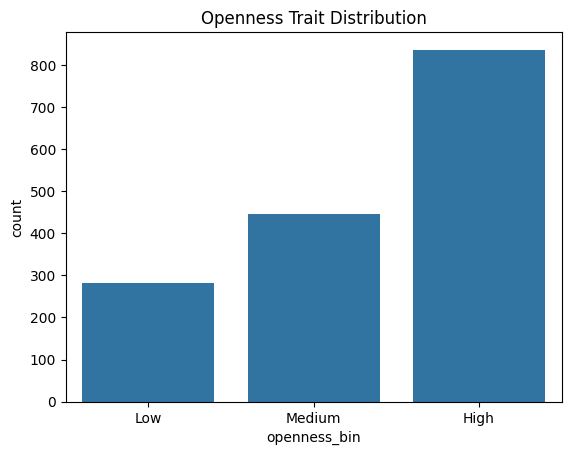

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

df['openness_bin'] = pd.cut(df['openness'] * 100, bins=[0, 32, 66, 100], labels=['Low', 'Medium', 'High'])
sns.countplot(x='openness_bin', data=df)
plt.title("Openness Trait Distribution")
plt.show()